my understanding is that i can take the boxes output and compare with the boxes values given by the data.<br>
Final report says IOU not good enough, need to know if the symbol is detected correctly so that means we'll need to get the word from the back and compare to the topic we detected and see how similar they are? WordEmbedModel??

I think the evaluation can just do with the IOU first at least for the week 8 meeting.
Ms Sailaja said we shld do precision, recall, and accuracy
precision = true positive/ all positive predictions
recall = true positive/ actual positive
accuracy is accuracy

but they have coco_eval and evaluate??? - ask abt this ig

Seniors Suggested
- add SentenceEmbreddeinModel to be able to handle Q&A + Slogans
- k-clustering for labels (they have a file /preprocess/clustered_symbol_lists)

In [1]:
from fasterrcnn_train import create_train_test_dataset
from dataset import AdsDataset
from detect import detect, draw_text
from preprocess.boxes import load_symbols_annotation
from preprocess.descriptors import load_annotation_json, SentimentPreProcessor
import cv2
import numpy as np
import pandas as pd

In [2]:
from matplotlib import pyplot as plt

In [3]:
ads_dataset = AdsDataset()
train, test = create_train_test_dataset(ads_dataset)

In [4]:
def bb_intersection_over_union(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[2])
    yA = max(boxA[1], boxB[3])
    xB = min(boxA[2], boxB[0])
    yB = min(boxA[3], boxB[1])

    # compute the area of intersection rectangle
    interArea = abs(max((xB - xA, 0)) * max((yB - yA), 0))
    if interArea == 0:
        return 0
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = abs((boxA[2] - boxA[0]) * (boxA[3] - boxA[1]))
    boxBArea = abs((boxB[2] - boxB[0]) * (boxB[3] - boxB[1]))

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)

    # return the intersection over union value
    return iou

In [8]:
#%%Get total iou, precision, recall
#https://jonathan-hui.medium.com/map-mean-average-precision-for-object-detection-45c121a31173

def get_total_iou(true, pred, descriptor, filename):
    if descriptor == "sentiments":
        df = pd.read_csv('predres.csv', index_col=None)
    else:
        df = pd.read_csv('fasterrcnn_res.csv', index_col = None)
    df = pd.DataFrame(df)
    for t in true:
        predlabels = []
        truelabels = []
        ious = []
        corrects = []
        filenames = []
        for p in pred:
            iou = bb_intersection_over_union(p[:4], t[:4])
            ious.append(iou)
            corrects.append(iou>=0.5)
            predlabels.append(p[4])
            truelabels.append(t[4])
            filenames.append(filename)
        df2 = pd.DataFrame({
                    "filename":filenames,
                    "iou": ious,
                    "correct?" : corrects,
                    "pred labels": predlabels,
                    "true labels": truelabels})
        df = df.append(df2, ignore_index=True)
    #print(df)
    if descriptor == "sentiments":
        df.to_csv('predres.csv', index=False)
    else:
        df.to_csv('fasterrcnn_res.csv', index=False)
    return "DONE"

In [6]:
# %% get the annotations for said files.
def testing(files, descriptor = "sentiments"):
   data = load_symbols_annotation() #loads the symbols.json file
   phrases = load_annotation_json() #loads the sentiments.json file
   prep = SentimentPreProcessor() #loads a dictionary for indexing phrase
   #get phrase, truth, and predicted bbox for each file
   for file in files:
      phrase_id = int(phrases[file][0][0])
      phrase = prep.id_to_word[phrase_id]
      filepath = "data/" + file
      preds = detect([filepath],  phrase, descriptor, "0", True)
      truth = data[file]
      get_total_iou(truth, preds, descriptor, file)
   return "DONE"



In [10]:
testing(test.dataset.image_path[:20], "original")

data/annotations/Sentiments.json


RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

## TESTING CODE BELOW

In [3]:
#%% first 10 files for testing the function
files = test.dataset.image_path[:3]

In [9]:
testing([files[2]])

data/annotations/Sentiments.json
TEST PREDICTIONS COMPLETE
[[71, 221, 249, 327, 'violence', 0.120133504], [61, 78, 235, 337, 'violence', 0.09435376], [54, 78, 246, 339, 'sex', 0.092009455], [100, 171, 220, 345, 'violence', 0.088896535], [101, 250, 207, 343, 'violence', 0.0727949], [2, 19, 308, 353, 'sex', 0.05925332], [66, 47, 212, 192, 'violence', 0.056183454], [31, 35, 248, 254, 'violence', 0.052093174]]


In [10]:
testing([files[2]], "original")

data/annotations/Sentiments.json
TEST PREDICTIONS COMPLETE
[[55, 54, 236, 357, 'sex', 0.12237799], [42, 22, 249, 335, 'beauty', 0.11320336], [89, 205, 220, 344, 'violence', 0.0742097], [60, 47, 216, 176, 'violence', 0.0688863], [52, 83, 259, 348, 'violence', 0.064791024], [34, 17, 253, 329, 'sexy', 0.056233153], [49, 40, 219, 194, 'sex', 0.056071434], [57, 213, 247, 345, 'sex', 0.055351675], [40, 17, 227, 175, 'beauty', 0.053884428], [79, 140, 209, 349, 'sex', 0.053622432]]


In [11]:
testing([files[0]])

data/annotations/Sentiments.json
TEST PREDICTIONS COMPLETE
[]


In [6]:
#get the third file from Symbol.json
data = load_symbols_annotation()
data[files[2]]

[[317.0, 479.0, 6.0, 168.0, 'Promiscuity '],
 [93.0, 355.0, 230.0, 474.0, 'sexual promiscuity '],
 [80.0, 335.0, 240.0, 479.0, 'well traveled'],
 [106.0, 347.0, 228.0, 491.0, 'use condoms']]

In [31]:
data[files[0]]

[[124.0, 251.0, 372.0, 463.0, 'irony/comedy'],
 [392.0, 468.0, 140.0, 139.0, 'entertainment']]

In [12]:
bbox1_original =[[55, 54, 236, 357, 'sex', 0.12237799], [42, 22, 249, 335, 'beauty', 0.11320336], 
[89, 205, 220, 344, 'violence', 0.0742097], [60, 47, 216, 176, 'violence', 0.0688863], [52, 83, 259, 348, 'violence', 0.064791024], 
[34, 17, 253, 329, 'sexy', 0.056233153], [49, 40, 219, 194, 'sex', 0.056071434], [57, 213, 247, 345, 'sex', 0.055351675], 
[40, 17, 227, 175, 'beauty', 0.053884428], [79, 140, 209, 349, 'sex', 0.053622432]]

bbox1_sentiment = [[71, 221, 249, 327, 'violence', 0.120133504], [61, 78, 235, 337, 'violence', 0.09435376], 
[54, 78, 246, 339, 'sex', 0.092009455], [100, 171, 220, 345, 'violence', 0.088896535], [101, 250, 207, 343, 'violence', 0.0727949], 
[2, 19, 308, 353, 'sex', 0.05925332], [66, 47, 212, 192, 'violence', 0.056183454], [31, 35, 248, 254, 'violence', 0.052093174]]

bbox2 = [[317.0, 479.0, 6.0, 168.0, 'Promiscuity '],
 [93.0, 355.0, 230.0, 474.0, 'sexual promiscuity '],
 [80.0, 335.0, 240.0, 479.0, 'well traveled'],
 [106.0, 347.0, 228.0, 491.0, 'use condoms']]

In [56]:
bb_intersection_over_union(bbox2[0][:4], bbox1_sentiment[7][:4])

0

In [60]:
arr1= np.array([[int(x) for x in (bbox1_sentiment[0][:4])]])
box_area(arr1)

array([18868])

In [61]:
arr1= np.array([[int(x) for x in (bbox2[0][:4])]])
box_area(arr1)

array([96721])

In [28]:
#from https://stackoverflow.com/questions/25349178/calculating-percentage-of-bounding-box-overlap-for-image-detector-evaluation#:~:text=You%27re%20calculating%20the%20area,%2F%20(union_area%20-%20intersection_area)%20.
#there are other methods i just picked this for now because it made the most sense
#more methods are available from the same link, below the main answer

def box_area(arr):
    width = arr[:, 2] - arr[:, 0]
    height = arr[:, 3] - arr[:, 1]
    return width * height

def _box_inter_union(arr1, arr2):
    # arr1 of [N, 4]
    # arr2 of [N, 4]
    area1 = box_area(arr1)
    area2 = box_area(arr2)

    # Intersection
    bottom_right = np.maximum(arr1[:, :2], arr2[:, :2]) # [[x, y]]
    top_left = np.minimum(arr1[:, 2:], arr2[:, 2:]) # [[x, y]]
    #print(top_left, bottom_right)
    wh = bottom_right - top_left
    # clip: if boxes not overlap then make it zero
    intersection = wh[:, 0].clip(0) * wh[:, 1].clip(0)

    #union 
    union = area1 + area2 - intersection
    return intersection, union

def box_iou(arr1, arr2):
    # N = number of bounding boxes

    #bottom right must be bigger than top left of truth
    #top left must be bigger than bottom right of truth
    # assert(arr1[:, :2] > arr2[:, 2:])
    # assert(arr1[:, 2:] < arr2[:, :2])
    
    inter, union = _box_inter_union(arr1, arr2)
    iou = inter / union
    return float(iou)
# box1 = np.array([[10, 10, 80, 80]])
# box2 = np.array([[20, 20, 100, 100]])
# box_iou(box1, box2)

In [66]:
print(bbox2[0][:2])
print(bbox2[0][2:4])
print(abs(bbox2[0][0]-bbox2[0][2])) #width
print(abs(bbox2[0][1]-bbox2[0][3])) #height
311*311

[317.0, 479.0]
[6.0, 168.0]
311.0
311.0


96721

In [84]:
print(bbox1_sentiment[6][:2])
print(bbox1_sentiment[6][2:4])
w = abs(bbox1_sentiment[6][0]-bbox1_sentiment[6][2]) #width
h = abs(bbox1_sentiment[6][1]-bbox1_sentiment[6][3]) #height
w*h

[66, 47]
[212, 192]


21170

In [85]:
boxA = bbox1_sentiment[6][:4]
boxB = bbox2[0][:4]
xA = max(boxA[0], boxB[2])
yA = max(boxA[1], boxB[3])
xB = min(boxA[2], boxB[0])
yB = min(boxA[3], boxB[1])

# compute the area of intersection rectangle
interArea = abs( max(0, xB - xA +1) * max(0, yB - yA+1))
print(xA, yA, xB, yB)
print(interArea)
interArea / float(21170 + 96721 - interArea)


66 168.0 212 192
3675.0


0.032175877285143935

In [47]:
bbox1_sentiment

[[71, 221, 249, 327, 'violence', 0.120133504],
 [61, 78, 235, 337, 'violence', 0.09435376],
 [54, 78, 246, 339, 'sex', 0.092009455],
 [100, 171, 220, 345, 'violence', 0.088896535],
 [101, 250, 207, 343, 'violence', 0.0727949],
 [2, 19, 308, 353, 'sex', 0.05925332],
 [66, 47, 212, 192, 'violence', 0.056183454],
 [31, 35, 248, 254, 'violence', 0.052093174]]

In [88]:
bb_intersection_over_union(bbox1_sentiment[0][:4], bbox2[0][:4])

0.19507656041604202

In [57]:
box_iou(bbox1_sentiment[0][:4], bbox2[0][:4])

[[ 71 221]] [[  6 168]]
[[249 327]] [[317 479]]


5.126192495230019

In [5]:
df = pd.read_csv('predres.csv', index_col=None)
print(df.head())

Empty DataFrame
Columns: [filename, iou, correct?, pred labels, true labels]
Index: []


In [37]:
def draw_bboxes(true, pred, filename):
    """
    true: truths from Symbols.json
    pred: predicted values from model
    """
    # bg_img = np.zeros([512,512,3],dtype=np.uint8)
    # bg_img.fill(255)
    img = cv2.imread("data/"+filename)                        # Read image
    bg_img = cv2.resize(img, (512, 512))
    for p in pred:
        cv2.rectangle(
                    bg_img,
                    (int(p[0]), int(p[1])),
                    (int(p[2]), int(p[3])),
                    (255,0,0),
                    2,)
        draw_text(
                        img=bg_img,
                        text=p[4] + " " + str(p[5]),
                        pos=(int(p[0]), int(p[1])),
                        text_color_bg=(255,0,0),
                        text_color = (0,0,0)
                    )

    for t in true:
        cv2.rectangle(
                bg_img,
                (int(t[0]), int(t[3])),
                (int(t[2]), int(t[1])),
                (0,255,0),
                2,)
        draw_text(
                        img=bg_img,
                        text=t[4],
                        pos=(int(t[0]), int(t[1])),
                        text_color_bg=(0,255,0),
                        text_color = (0,0,0)
                    )
    
    return bg_img

In [116]:
get_total_iou(bbox2, bbox1_sentiment, "sentiment")
get_total_iou(bbox2, bbox1_original, "original")

'DONE'

In [7]:
phrases = load_annotation_json()

data/annotations/Sentiments.json


In [9]:
phrases['10/171489.png']

[['12'], ['19'], ['3', '4']]

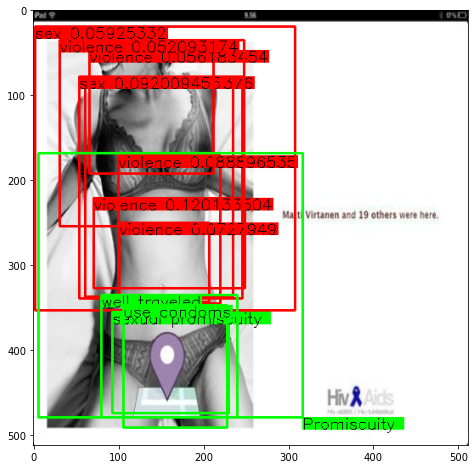

In [38]:
img = draw_bboxes(bbox2, bbox1_sentiment, files[2])
plt.figure(figsize = (8,8))
plt.imshow(img)

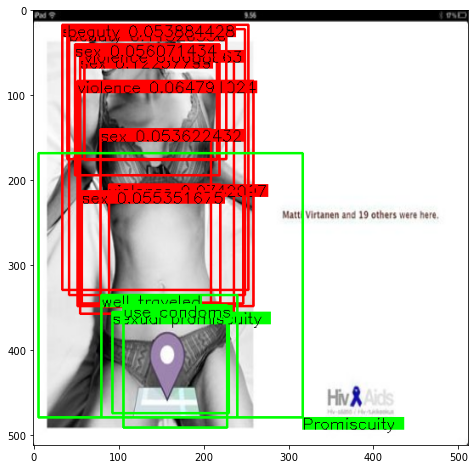

In [39]:
img = draw_bboxes(bbox2, bbox1_original, files[2])
plt.figure(figsize = (8,8))
plt.imshow(img)

In [25]:
files[2]

'10/171489.png'

In [26]:
bbox2

[[317.0, 479.0, 6.0, 168.0, 'Promiscuity '],
 [93.0, 355.0, 230.0, 474.0, 'sexual promiscuity '],
 [80.0, 335.0, 240.0, 479.0, 'well traveled'],
 [106.0, 347.0, 228.0, 491.0, 'use condoms']]